# Run this code block to install dependencies

In [ ]:
# !git clone https://github.com/KenzaB27/TransUnet.git
# %cd TransUnet
# !pip install -r requirements.txt 
# %cd ..

In [1]:
%cd TransUnet
import models.transunet as transunet
import utils.visualize as visualize
import experiments.config as conf
import importlib
%cd ..

/Users/srinathramalingam/Desktop/codebase/TransUnet/TransUnet
/Users/srinathramalingam/Desktop/codebase/TransUnet


In [2]:
import os
import argparse
import pandas as pd
import tensorflow as tf
from bp import Environment
import TransUnet.experiments.config as conf
from dTurk.utils.clr_callback import CyclicLR
import TransUnet.models.transunet as transunet
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from train_helpers import dice_loss, mean_iou, oversampling, create_dataset

Segmentation Models: using `tf.keras` framework.


In [3]:
env = Environment()

config = conf.get_transunet()
config['image_size'] = 256
config["filters"] = 3
config['n_skip'] = 3
config['decoder_channels'] = [128, 64, 32, 16]
config['resnet']['n_layers'] = (3,4,9,12)
config['dropout'] = 0.1
config['grid'] = (28,28)
config["n_layers"] = 12

In [4]:
config

decoder_channels:
- 128
- 64
- 32
- 16
dropout: 0.1
filters: 3
grid: !!python/tuple
- 28
- 28
hidden_size: 768
hybrid: true
image_size: 256
kernel_size: 1
mlp_dim: 3072
n_heads: 12
n_layers: 12
n_skip: 3
name: TransUNet
patch_size: 16
pretrained_filename: R50+ViT-B_16.npz
resnet:
  n_layers: !!python/tuple
  - 3
  - 4
  - 9
  - 12
  width_factor: 1
upsampling_factor: 1

In [5]:
dataset = "MACH-77-it3"
machine = "local"
monitor = "val_loss"
epochs = 75
patience = 12
batch_size = 32
lr = 0.005
train_augmentation_file = "/Users/srinathramalingam/Desktop/codebase/dTurk/dTurk/augmentation/configs/light.yaml"
save_path = "weights/TransUnet"
checkpoint_filepath = save_path + "/checkpoint/"

In [6]:
dataset_directory = os.environ.get("BP_PATH_REMOTE") + "/datasets/semseg_base" + "/" + dataset

In [7]:
try:
    gpus = tf.config.list_physical_devices("GPU")
    tf.config.set_visible_devices(gpus[args_dict["gpu"]], "GPU")
except:
    print("Gpus not found")

Gpus not found


In [8]:
train_input_names = [
    dataset_directory + "/train_labels/" + i
    for i in os.listdir(dataset_directory + "/train_labels/")
    if i.endswith(".png")
]
val_input_names = [
    dataset_directory + "/val/" + i for i in os.listdir(dataset_directory + "/val/") if i.endswith(".png")
]

In [9]:
train_input_names = oversampling(train_input_names, machine, dataset, -1)
train_ds_batched, val_ds_batched = create_dataset(train_input_names, val_input_names, train_augmentation=train_augmentation_file)

100%|████████████████████████████████████████████| 90/90 [00:00<00:00, 273.08it/s]
/Users/srinathramalingam/opt/anaconda3/envs/bv2/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/Users/srinathramalingam/opt/anaconda3/envs/bv2/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
2022-06-30 10:10:56.996702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
step_size = int(2.0 * len(train_input_names) / batch_size)

In [11]:
network = transunet.TransUnet(config, trainable=False)

ListWrapper([128, 64, 32, 16])


In [12]:
network.model.compile(optimizer="adam", loss=dice_loss, metrics=mean_iou)

In [13]:
callbacks = []
checkpoint_path = checkpoint_filepath+"/cp-{epoch:04d}.ckpt"

cyclic_lr = CyclicLR(
    base_lr=lr / 10.0,
    max_lr=lr,
    step_size=step_size,
    mode="triangular2",
    cyclic_momentum=False,
    max_momentum=False,
    base_momentum=0.8,
)
callbacks.append(cyclic_lr)

early_stopping = EarlyStopping(
    monitor=monitor,
    mode="min" if "loss" in monitor else "max",
    patience=patience,
    verbose=1,
    restore_best_weights=True,
)
callbacks.append(early_stopping)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size
)
callbacks.append(cp_callback)

In [14]:
history = network.model.fit(
    train_ds_batched, epochs=100, validation_data=val_ds_batched, callbacks=[callbacks]
)

Epoch 1/100
11/11 [==============================] - 102s 9s/step - loss: 0.5568 - mean_iou: 0.7818 - val_loss: 0.5385 - val_mean_iou: 0.4178
Epoch 2/100
11/11 [==============================] - 94s 9s/step - loss: 0.4914 - mean_iou: 0.9414 - val_loss: 0.3982 - val_mean_iou: 0.9522
Epoch 3/100
 7/11 [==================>...........] - ETA: 40s - loss: 0.4504 - mean_iou: 0.9388

KeyboardInterrupt: 

In [ ]:
iou = history.history["mean_iou"]
val_iou = history.history["val_mean_iou"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

df = pd.DataFrame(iou)
df.columns = ["mean_iou"]
df["val_mean_iou"] = val_iou
df["loss"] = loss
df["val_loss"] = val_loss

df.to_csv("TransUnet-logs.csv")

In [ ]:
# network.model.load_weights(checkpoint_filepath)
# saved_model_path = save_path + "/model"
# network.model.save(saved_model_path)

network.model.save_weights(checkpoint_filepath+'/TransUnet.h5')
network.model.load_weights(checkpoint_filepath+'/TransUnet.h5')
saved_model_path = save_path + "/model"
network.model.save(saved_model_path)

In [ ]:
import cv2
import dTurk.models.sm_models as sm
from dTurk.models.SM_UNet import SM_UNet_Builder

In [ ]:
import cv2
import dTurk.models.sm_models as sm
from dTurk.models.SM_UNet import SM_UNet_Builder

builder = SM_UNet_Builder(
    encoder_name='efficientnetv2-l',
    input_shape=(256, 256, 3),
    num_classes=3,
    activation="softmax",
    train_encoder=False,
    encoder_weights="imagenet",
    decoder_block_type="upsampling",
    head_dropout=0,  # dropout at head
    dropout=0,  # dropout at feature extraction
)
model2 = builder.build_model()
model2.load_weights("/Users/srinathramalingam/Desktop/codebase/TransUnet/weights/Unet/checkpoint/Unet.h5")

In [ ]:
def predict(image, model1, model2, file):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.array(img)/255
    img = img.reshape((1,256,256,3))
    prediction1 = model1.predict(img)
    prediction1 = tf.clip_by_value(prediction1, 0.0, 1.0)
    prediction2 = model2.predict(img)
    prediction2 = tf.clip_by_value(prediction2, 0.0, 1.0)
    pred1 = prediction1 * 255
    pred1 = np.array(prediction1).reshape((256,256,3))
    pred2 = prediction2 * 255
    pred2 = np.array(prediction2).reshape((256,256,3))
    img = img.reshape((256,256,3))
    return img, pred1, pred2

In [ ]:
val_input_names = ["/Users/srinathramalingam/Desktop/codebase/Jupyter_predictions_Nearspace/MACH-77-it2/val/images/" + i for i in os.listdir("/Users/srinathramalingam/Desktop/codebase/Jupyter_predictions_Nearspace/MACH-77-it2/val/images")]

In [ ]:
for file in range(len(val_input_names)):
    img, pred1, pred2 = predict(val_input_names[file], network.model, model2, file)
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)

    plt.subplot(1, 3, 2)
    plt.imshow(pred1)

    plt.subplot(1, 3, 3)
    plt.imshow(pred2)

    plt.show()

In [16]:
save_path = "weights"
saved_model_path = save_path + "/model"
model = tf.keras.models.load_model(
    saved_model_path, compile=False)

1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


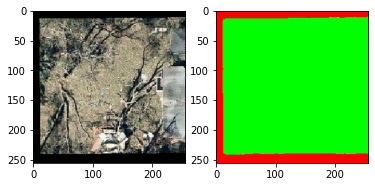

1/1 [==============================] - 0s 397ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


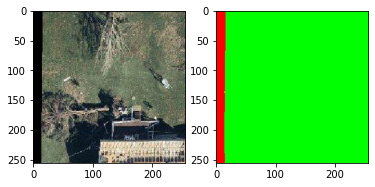

1/1 [==============================] - 0s 361ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


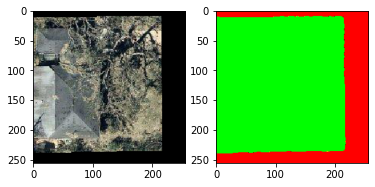

1/1 [==============================] - 0s 372ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


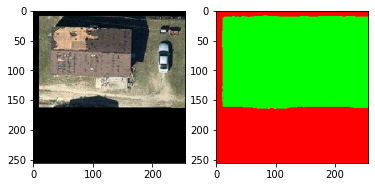

1/1 [==============================] - 0s 352ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


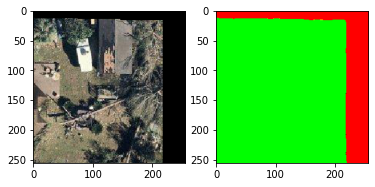

1/1 [==============================] - 0s 385ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


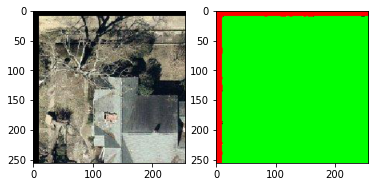

1/1 [==============================] - 0s 375ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


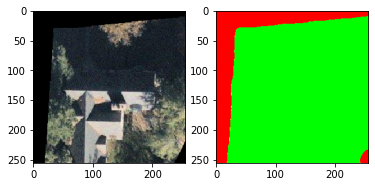

1/1 [==============================] - 0s 390ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


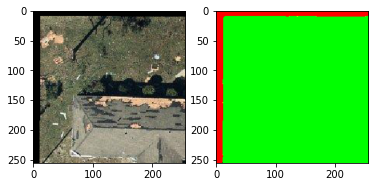

1/1 [==============================] - 0s 339ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


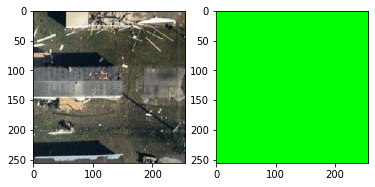

1/1 [==============================] - 0s 338ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


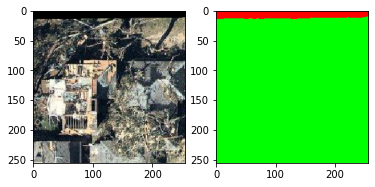

1/1 [==============================] - 0s 393ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


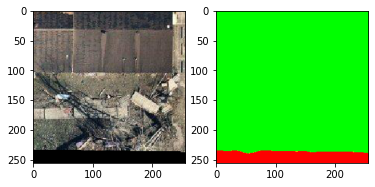

1/1 [==============================] - 0s 390ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


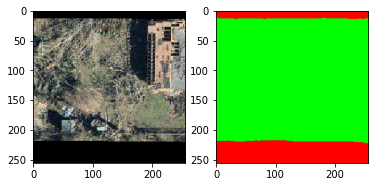

1/1 [==============================] - 0s 380ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


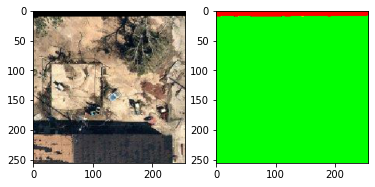

1/1 [==============================] - 0s 385ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


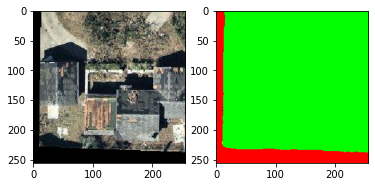

1/1 [==============================] - 0s 369ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


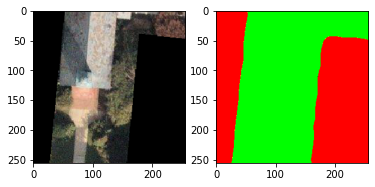

1/1 [==============================] - 0s 379ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


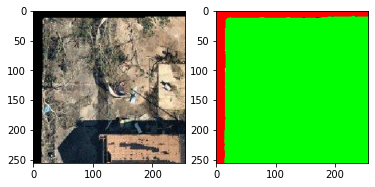

1/1 [==============================] - 0s 373ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


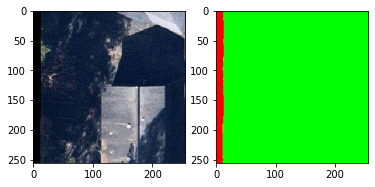

1/1 [==============================] - 0s 392ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


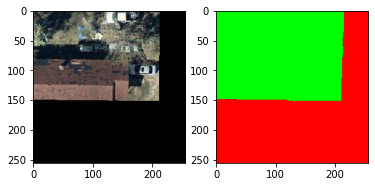

1/1 [==============================] - 0s 396ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


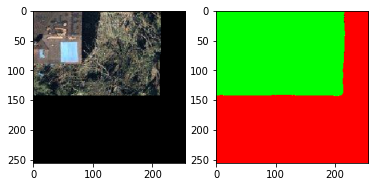

1/1 [==============================] - 0s 388ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


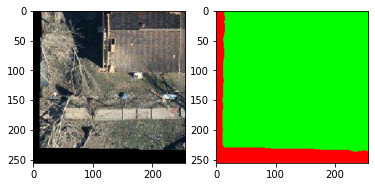

1/1 [==============================] - 0s 380ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


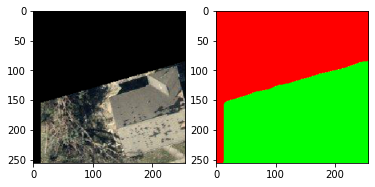

1/1 [==============================] - 0s 398ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


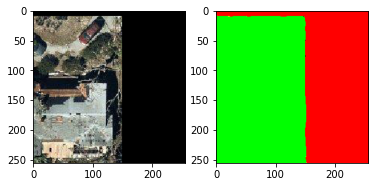

1/1 [==============================] - 0s 392ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


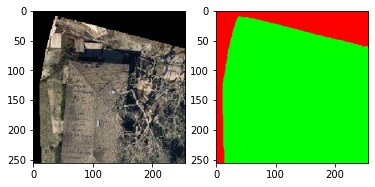

1/1 [==============================] - 0s 394ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


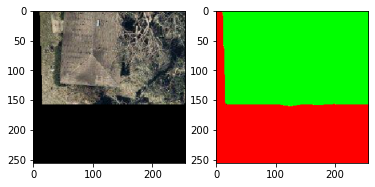

1/1 [==============================] - 0s 383ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


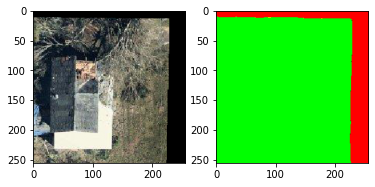

1/1 [==============================] - 0s 378ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


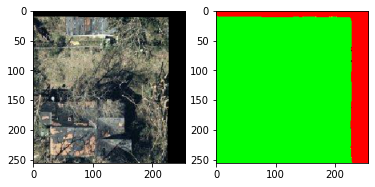

1/1 [==============================] - 0s 358ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


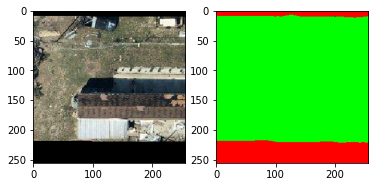

1/1 [==============================] - 0s 398ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


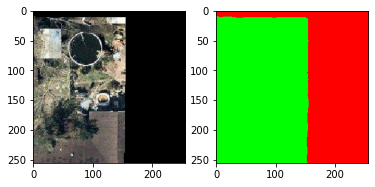

1/1 [==============================] - 0s 385ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


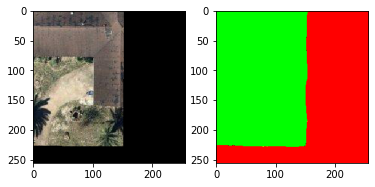

1/1 [==============================] - 0s 374ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


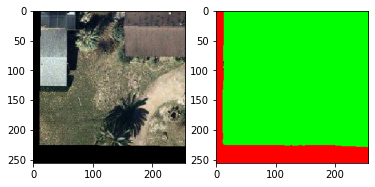

In [17]:
val_input_names = ["/Users/srinathramalingam/Desktop/codebase/Jupyter_predictions_Nearspace/MACH-77-it2/val/images/" + i for i in os.listdir("/Users/srinathramalingam/Desktop/codebase/Jupyter_predictions_Nearspace/MACH-77-it2/val/images")]

import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict(image, model,):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.array(img)/255
    img = img.reshape((1,256,256,3))
    prediction = model.predict(img)
    prediction = tf.clip_by_value(prediction, 0.0, 1.0)
    pred = prediction * 255
    pred = np.array(pred).reshape((256,256,3))
    img = img.reshape((256,256,3))
    return img, pred


for file in range(len(val_input_names)):
    img, pred1 = predict(val_input_names[file], model)
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(pred1)

    plt.show()